**CRIB SHEET RULES OF THE ROAD:**

This crib sheet is provided to support access, utilization, and plotting of UCalgary optical datasets. It is intended as a base set of code that a user may edit and manipulate to serve their own needs.  Crib sheets contains UCalgary verified and validated procedures for plotting and manipulating UCalgary ASI data for common use cases.  Use of this crib sheet does not require acknowledgment, it is freely distributed for scientific use. Please also remember to perform due diligence on all data use.  We recommend comparison with verified data products on [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca) to ensure that any user output does not contradict operational summary plots.  Data use must be acknowledged according to the information available for each data set - please see [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca).  If you encounter any issues with the data or the crib sheet, please contact the UCalgary team for support (Emma Spanswick, elspansw@ucalgary.ca). Copyright © University of Calgary.

---
# **Working with AuroraX satellite location data and ASIs**
---

### **Datasets**

In a digital All-Sky Imager (ASI), an optical system (fisheye lens, filters, etc.) projects an image of the full ('2$\pi$ sky') onto the plane of a detector (CCDs, CMOS, or other). For a single 'capture', the output is an image, with each pixel corresponding to an azimuth and elevation. Data numbers within the image convey information about the brightness of the sky in the respective directions. That information might be simply related to brightness in a narrow wavelength band (e.g., REGO, TREx Blueline, TREx NIR, a NASCAM channel, etc.), or related in a more complex way to brightness across broad ranges of wavelengths (e.g., THEMIS ASI, TREx RGB).

Datasets from UCalgary geospace remote sensing projects can be found at https://data.phys.ucalgary.ca. This crib sheet pertains to single channel systems:
- THEMIS ASI
- REGO
- TREx NIR
- TREx Blueline
- NORSTAR NASCAM

### **Crib Sheet Summary**

The code and supporting documentation in this file outlines the basics of working with the AuroraX search engine to retrieve satellite location data, and plotting it in a mosaic of ASI data.


</br>

---

</br>


## **Install dependencies**

Here we'll install [PyAuroraX](https://github.com/aurorax-space/pyaurorax), and import it.

Some helpful links:
  - [PyAuroraX documentation](https://docs.aurorax.space/code/overview)
  - [PyAuroraX API Reference](https://docs.aurorax.space/code/pyaurorax_api_reference/pyaurorax)
  - [Jupyter notebook examples](https://github.com/aurorax-space/pyaurorax/tree/main/examples/notebooks)


In [ ]:
!pip install -i https://test.pypi.org/pypi/ --extra-index-url https://pypi.org/simple pyaurorax==1.0.0-rc3

In [15]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pyaurorax
import cartopy

aurorax = pyaurorax.PyAuroraX()
at = aurorax.tools

## **Download and Read Data**

We need to download the data we're going to be using. PyAuroraX provides functions to handle this for you. You can learn more about how to use them by looking at the 'Data download` crib sheet, reading the PyAuroraX documentation, or the PyAuroraX API reference. Links are above.

If you prefer our other methods to download the data (basic HTTP, FTP, Rsync), that is also possible. You would download the data and skip to the data reading step of this crib sheet.

In [7]:
# We can set the path of where we want to save data to. By default,
# PyAuroraX saved data to your home directory. Since we can be running
# this crib sheet on Google Colab, we're going to do a special case
# and set the path if running in Colab. We'll leave the default if
# running in a different environment.
import sys
if ("google.colab" in sys.modules):
    aurorax.download_output_root_path = "/content/ucalgary_data"
    aurorax.read_tar_temp_path = "/content/ucalgary_data/tar_temp_working"
print(aurorax)

PyAuroraX(download_output_root_path='C:\Users\darrenc\pyaurorax_data', read_tar_temp_path='C:\Users\darrenc\pyaurorax_data\tar_temp_working', api_base_url='https://api.aurorax.space', api_headers={'content-type': 'application/json', 'user-agent': 'python-pyaurorax/1.0.0-rc3'}, api_timeout=10, api_key='None', srs_obj=PyUCalgarySRS(...))


In [9]:
# download a minute of RGB data from several sites
dataset_name = "TREX_RGB_RAW_NOMINAL"
start_dt = datetime.datetime(2023, 2, 24, 7, 5)
end_dt = start_dt
site_uid_list = ['yknf', 'gill', 'rabb', 'luck', 'atha']
data_download_objs = {}
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download(dataset_name, start_dt, end_dt, site_uid=site_uid)
    data_download_objs[site_uid] = download_obj

# Read in the data site-by-site, as we need this separation for mosaicing
data_list = []
for site_uid, download_obj in data_download_objs.items():
    data_list.append(aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames))

In [10]:
# Get list of all skymaps in previous two years up to date of interest for each site
skymap_download_objs = {}
for site_uid in site_uid_list:
    download_obj = aurorax.data.ucalgary.download(
        "TREX_RGB_SKYMAP_IDLSAV",
        start_dt.replace(year=start_dt.year - 2),
        start_dt,
        site_uid=site_uid,
    )
    skymap_download_objs[site_uid] = download_obj

# Read and store the last list index skymap for each site, as that is most recent to the date of interest
skymaps = []
for site_uid, download_obj in skymap_download_objs.items():

    skymap = aurorax.data.ucalgary.read(download_obj.dataset, download_obj.filenames[-1])
    skymaps.append(skymap.data[0])

skymaps

[Skymap(project_uid=rgb, site_uid=yknf, imager_uid=rgb-08, site_map_latitude=62.519848, site_map_longitude=245.686966, ...),
 Skymap(project_uid=rgb, site_uid=gill, imager_uid=rgb-04, site_map_latitude=56.376724, site_map_longitude=265.356323, ...),
 Skymap(project_uid=rgb, site_uid=rabb, imager_uid=rgb-06, site_map_latitude=58.227810, site_map_longitude=256.319366, ...),
 Skymap(project_uid=rgb, site_uid=luck, imager_uid=rgb-03, site_map_latitude=51.153988, site_map_longitude=252.735260, ...),
 Skymap(project_uid=rgb, site_uid=atha, imager_uid=rgb-07, site_map_latitude=54.602631, site_map_longitude=246.355728, ...)]

## **Build ASI mosaic**

First, we'll create our mosaic using the ASI data. Later on, we'll overplot the satellite location information.

In [12]:
# prepare the skymap data
prepped_skymap = at.mosaic.prep_skymaps(skymaps, 110, n_parallel=2)

# prepare the image data
prepped_images = at.mosaic.prep_images(data_list)

Preparing skymaps:   0%|          | 0/5 [00:00<?, ?skymap/s]

In [14]:
# define the intensity scales for each site
scale = {
    "yknf": [10, 90],
    "gill": [10, 90],
    "rabb": [10, 90],
    "luck": [10, 90],
    "atha": [10, 90],
}

# create projection
center_lat = -100.0
center_lon = 55.0
projection_obj = cartopy.crs.NearsidePerspective(central_longitude=center_lat, central_latitude=center_lon)

# create mosaic
frame_num = 0
mosaic = at.mosaic.create(prepped_images, prepped_skymap, frame_num, projection_obj, image_intensity_scales=scale)


map_extent = [-140, -70, 35, 75]
dt = data_list[0].timestamp[0]

# Add geographic gridlines using many lines of constant lat and lon. These will go behind the image data
lat_locs = np.arange(0, 90, 10)
lon_locs = np.arange(-180, 0, 20)

# Add gridlines
mosaic.add_geo_contours(constant_lats=lat_locs, constant_lons=lon_locs, linestyle='--', color='black')

## **Overplot Satellite Location Data**

Now that we have our mosaic created using the ASI data, we need to retrieve some satellite location data. We will utilize the AuroraX search engine for this, searching for 'ephemeris' data.

More information about performing AuroraX ephemeris and conjunction searches can be found [here](https://docs.aurorax.space/code/basic_usage/overview/).

In [17]:
# Set values of interest - let's grab 30 minutes of data from Swarm A
start = datetime.datetime(2023, 2, 24, 6, 50, 0)
end = datetime.datetime(2023, 2, 24, 7, 20, 0)
programs = ["swarm"]
platforms = ["swarma"]
instrument_types = ["footprint"]

# Perform search
s = aurorax.search.ephemeris.search(start, end, programs=programs, platforms=platforms, instrument_types=instrument_types, verbose=True)

# Organize data into a list of dicts
ephemeris_data = [e.__dict__ for e in s.data]

# Create lists of lats and lons for all timestamps
lats = []
lons = []
for i in range(len(ephemeris_data)):
    lats.append(ephemeris_data[i]['location_geo'].lat)
    lons.append(ephemeris_data[i]['location_geo'].lon)

# Add the footprint of Swarm A over 30 minutes
mosaic.add_geo_contours(lats=lats, lons=lons, linestyle='-', color='red', bring_to_front=True)

# Get exact location of satellite at time of mosaic
start = datetime.datetime(2023, 2, 24, 7, 5, 0)
end = datetime.datetime(2023, 2, 24, 7, 5, 0)
programs = ["swarm"]
platforms = ["swarma"]
instrument_types = ["footprint"]

s = aurorax.search.ephemeris.search(start, end, programs=programs, platforms=platforms, instrument_types=instrument_types, verbose=True)

# Organize data into a list of dicts
ephemeris_data = [e.__dict__ for e in s.data]

# Create lists of lats and lons for all timestamps
lats = []
lons = []
for i in range(len(ephemeris_data)):
    lats.append(ephemeris_data[i]['location_geo'].lat)
    lons.append(ephemeris_data[i]['location_geo'].lon)

[2024-06-19 13:57:36.080508] Search object created
[2024-06-19 13:57:36.110166] Request submitted
[2024-06-19 13:57:36.110166] Request ID: b6846f18-1003-466c-99d2-1fde8fa70577
[2024-06-19 13:57:36.110166] Request details available at: https://api.aurorax.space/api/v1/ephemeris/requests/b6846f18-1003-466c-99d2-1fde8fa70577
[2024-06-19 13:57:36.110166] Waiting for data ...
[2024-06-19 13:57:37.219493] Checking for data ...
[2024-06-19 13:57:37.294131] Data is now available
[2024-06-19 13:57:37.294131] Retrieving data ...
[2024-06-19 13:57:37.362863] Retrieved 177.5 kB of data containing 31 records
[2024-06-19 13:57:37.367746] Search object created
[2024-06-19 13:57:37.395189] Request submitted
[2024-06-19 13:57:37.395189] Request ID: 520bfdeb-c5ce-44ef-9195-ca83a9f6ff84
[2024-06-19 13:57:37.395189] Request details available at: https://api.aurorax.space/api/v1/ephemeris/requests/520bfdeb-c5ce-44ef-9195-ca83a9f6ff84
[2024-06-19 13:57:37.395189] Waiting for data ...
[2024-06-19 13:57:38.48

In [18]:
# Add the location of SWARM A at the exact time of this mosaic
mosaic.add_geo_contours(lats=lats, lons=lons, color='red', bring_to_front=True, marker="o")

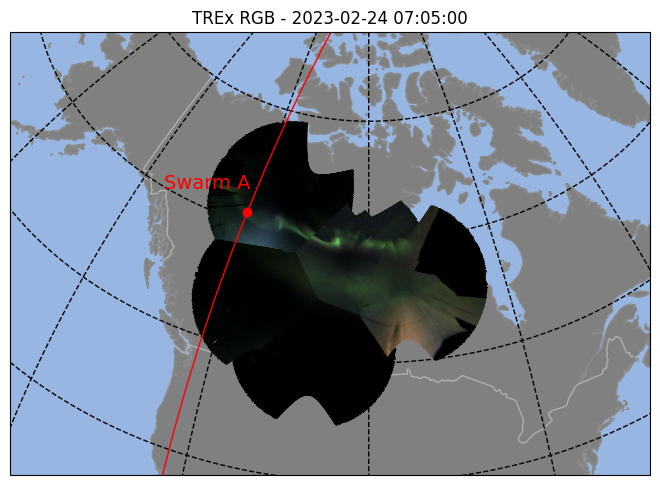

In [19]:
# Obtain mosaic plot so we can do some custom things to it
fig, geo_axes = mosaic.plot(map_extent, title="TREx RGB - %s" % (dt.strftime("%Y-%m-%d %H:%M:%S")), returnfig=True)

# Plot the mosaic and add some of our own text
plt.figure(fig.number)
geo_axes.text(lons[0]-15,lats[0]-1,"Swarm A", color="red", transform=cartopy.crs.PlateCarree(), fontsize=14)  # Add label for satellite
plt.show()